# Polish Traffic Signs Recognition


In [1]:
# Global variables
DATA_PATH = './drive/MyDrive/PolishTrafficSignsRecognition/'
TRAIN_DATA_PATH = DATA_PATH + 'train/'
TEST_DATA_PATH = DATA_PATH + 'test/'
PICKLE_DATA_PATH = DATA_PATH + 'pickleData/'
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES_200 = 22
NUM_CLASSES_100 = 42

# Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import cv2
import random
import pickle

# DL imports
import keras
from keras import optimizers
from keras import models
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report

# 1. Data

## 1.1 Checking the data

### 1.1.1 Check if all signs are in both train & test dirs

In [2]:
train_signs_dirs = [dir for dir in os.listdir(TRAIN_DATA_PATH)]
test_signs_dirs = [dir for dir in os.listdir(TEST_DATA_PATH)]
print(f'Negative intersection train_signs_dirs ^ test_signs_dirs = {set(train_signs_dirs) ^ set(test_signs_dirs)}')
print(f'Number of classes train_signs_dirs: {len(train_signs_dirs)}')
print(f'Number of classes test_signs_dirs: {len(test_signs_dirs)}')

Negative intersection train_signs_dirs ^ test_signs_dirs = set()
Number of classes train_signs_dirs: 92
Number of classes test_signs_dirs: 92


So we know that both train and test sets have the same kinds of traffic signs


### 1.1.2 Check the number of train and test cases

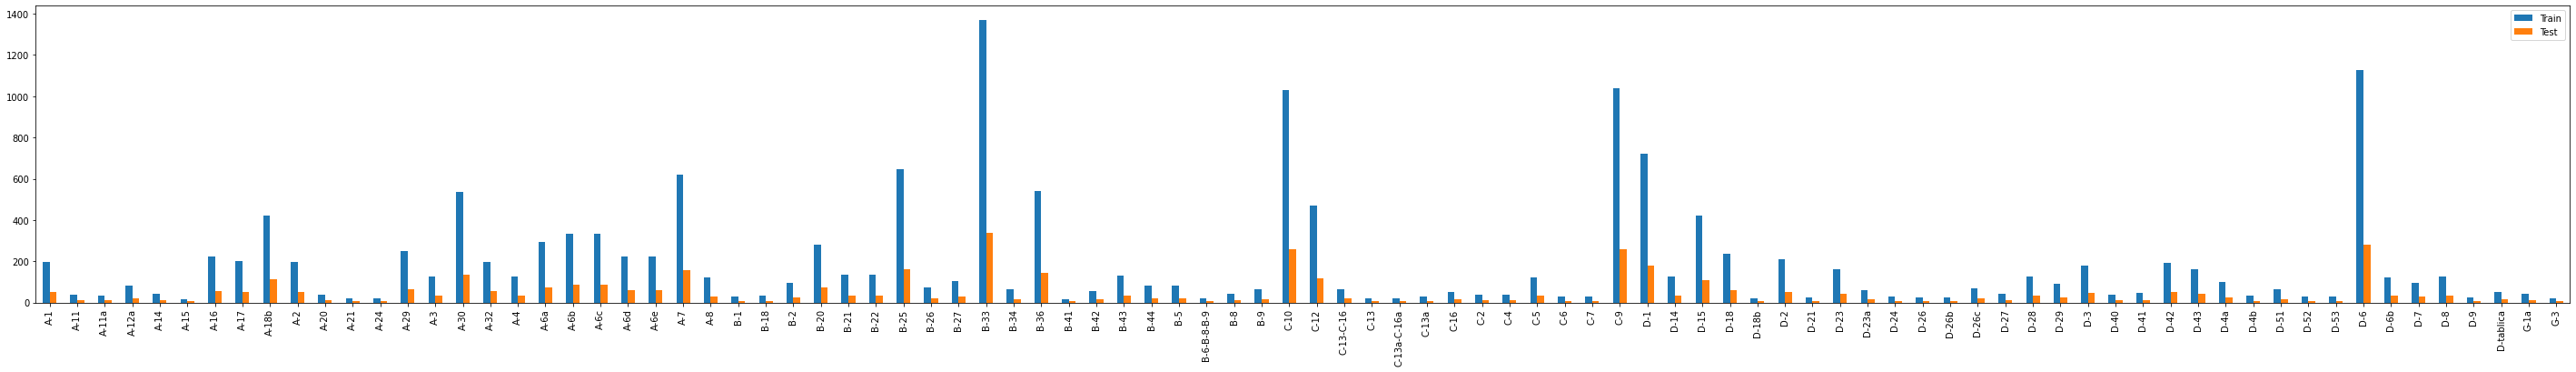



The lowest # of images in the train set dir: 15 
The highest # of images in the train set dir: 1370


In [3]:
train_signs_counts = [len(os.listdir(TRAIN_DATA_PATH + dir)) for dir in os.listdir(TRAIN_DATA_PATH)]
test_signs_counts = [len(os.listdir(TEST_DATA_PATH + dir)) for dir in os.listdir(TEST_DATA_PATH)]

df = pd.DataFrame(np.c_[train_signs_counts, test_signs_counts], index=train_signs_dirs)
df.plot.bar(figsize=(50,6))
plt.legend(['Train','Test'])
plt.show()

print(f'\n\nThe lowest # of images in the train set dir: {min(train_signs_counts)} \nThe highest # of images in the train set dir: {max(train_signs_counts)}')

As we see, the numbers of images of each traffic sign highly differ between themselves. Thus the given dataset is highly imbalanced.

#### Ways of deadling with imbalanced data

1. **Gather more data** - not really possible having in mind available time and energy for this project.

3. **Resampling Data** - both under-sampling and over-sampling will be used
4. **Data Augmentation** - will be used
5. **Different Algorithms** - as this project focuses on CNN this method will not be considered
6. **Penalization** - setting bigger weights on under-represented classes in order to put more pressure on classifing them correctly. It will be used in this project. 


Source: [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset ~ Jason Brownlee](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)

### 1.1.3 Check # of samples in specified ranges

In [4]:
# Checking the amount of the samples 

colective_count = np.zeros(5)
borders = [1000, 500, 400, 200, 100]
for count in train_signs_counts:
  for i in range(0, len(borders)):
    if count > borders[i]:
      colective_count[i] += 1

for i in range(0,5):
  print(f'Signs with # of train samples > {borders[i]} = {colective_count[i]}')
print(f'Signs with # of train samples <=100 = {len(train_signs_counts) - colective_count[-1]}')

Signs with # of train samples > 1000 = 4.0
Signs with # of train samples > 500 = 9.0
Signs with # of train samples > 400 = 12.0
Signs with # of train samples > 200 = 22.0
Signs with # of train samples > 100 = 42.0
Signs with # of train samples <=100 = 50.0


As we can see there are not a lot of classes with a lot of samples. In my further work I will use signs with >200 samples and >100 samples (with over-sampling and augmentation) to feed them into CNN.

I've decided to check 3 subsets:
- signs with more that 200 samples - 200 samples of each sign goes to subset
- signs with more that 100 samples - 200 samples (with augmentation) goes to subset
- signs with more that 100 samples - 200 samples (with over-sampling) goes to subset

And additionaly the whole dataset with weightening to balance the data imbalance

### 1.1.4 Check train-test split ratio

In [5]:
# Checking the train-test split ratio

ratios = []
for i in range(0,len(train_signs_counts)):
  ratios.append(train_signs_counts[i]/(train_signs_counts[i] + test_signs_counts[i]))

print(f'Mean ratio of train/(train+test) = {np.mean(ratios)}, standard deviation = {np.std(ratios)}')

Mean ratio of train/(train+test) = 0.7884157455988144, standard deviation = 0.011628437254499458


As we can see training data makes around 80% of traffic sign samples. In order to obtain validation set, I will split test sets in half to obtain train-val-test ratio equal 80:10:10.

I take validation set from test set not training set, as I don't want to further reduce the number of samples available for network's training.

## 1.3 Loading & preparing the data for CNNs

In [6]:
# Functions which will be used

def reshape_images(images):
  result = []
  for img in images:
    reshaped = cv2.resize(img, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
    result.append(reshaped)
  return result

def read_images(localization ,list_of_dirs, number_of_images_to_read, oversample = False, augment = False):
  result = []
  for dir in list_of_dirs:
    subresult = []
    i = 0
    for sign_image_name in os.listdir(os.path.join(localization,dir)):
      sign_image = mpimg.imread(os.path.join(localization, dir, sign_image_name))
      subresult.append((sign_image, dir))
      i += 1
      if i == number_of_images_to_read:
        break
    result += subresult
    if oversample:
      choices = np.random.choice(len(subresult), 200 - len(subresult))
      result += [subresult[i] for i in choices]
    if augment:
      generator = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             brightness_range=(0.5,1),
                             shear_range=20.0,
                             zoom_range=0.1,
                             channel_shift_range=100.0,
                             )
      augmented = []
      signs_length = len(subresult)
      j = 0
      while i < number_of_images_to_read:
        data = img_to_array(subresult[j % signs_length][0])
        samples = np.expand_dims(data, 0)
        it = generator.flow(samples, batch_size=1)
        batch = it.next()
        augmented.append((batch[0].astype('uint8'), dir))
        i += 1
        j += 1
      result += augmented
  return result

### 1.3.1 Loading images

In [7]:
# Functions which will be used

def save_images_data(images, file_name):
  with open(PICKLE_DATA_PATH + file_name, 'wb') as filehandle:
    pickle.dump(images, filehandle)

def load_images_data(file_name):
  with open(PICKLE_DATA_PATH + file_name, 'rb') as filehandle:
    images = pickle.load(filehandle)
  return images

In [8]:
dirs_above_200 = []
dirs_above_100 = []
for i in range(0, len(train_signs_dirs)):
  if train_signs_counts[i] > 200:
    dirs_above_200.append(train_signs_dirs[i])
  if train_signs_counts[i] > 100:
    dirs_above_100.append(train_signs_dirs[i])

In [9]:
# Read >200
# train
if not os.path.isfile(PICKLE_DATA_PATH + 'images200_train.data'):
  images200_train = read_images(TRAIN_DATA_PATH, dirs_above_200, 200)
  random.shuffle(images200_train)
  save_images_data(images200_train, 'images200_train.data')
else:
  images200_train = load_images_data('images200_train.data')

# test & valid
if not (os.path.isfile(PICKLE_DATA_PATH + 'images200_test.data') or os.path.isfile(PICKLE_DATA_PATH + 'images200_valid.data')):
  images200_test = read_images(TEST_DATA_PATH, dirs_above_200, 200)
  random.shuffle(images200_test)
  images200_valid = images200_test[:len(images200_test)//2]
  images200_test = images200_test[len(images200_test)//2:]
  save_images_data(images200_test, 'images200_test.data')
  save_images_data(images200_valid, 'images200_valid.data')
else:
  images200_test = load_images_data('images200_test.data')
  images200_valid = load_images_data('images200_valid.data')

In [31]:
# Read >100 + over-sampling
# train
if not os.path.isfile(PICKLE_DATA_PATH + 'images100_sampled_train.data'):
  images100_sampled_train = read_images(TRAIN_DATA_PATH, dirs_above_100, 200, oversample = True)
  random.shuffle(images100_sampled_train)
  save_images_data(images100_sampled_train, 'images100_sampled_train.data')
else:
  images100_sampled_train = load_images_data('images100_sampled_train.data')

# test & valid
if not (os.path.isfile(PICKLE_DATA_PATH + 'images100_sampled_test.data') or os.path.isfile(PICKLE_DATA_PATH + 'images100_sampled_valid.data')):
  images100_sampled_test = read_images(TEST_DATA_PATH, dirs_above_100, 200)
  random.shuffle(images100_sampled_test)
  images100_sampled_valid = images100_sampled_test[:len(images100_sampled_test)//2]
  images100_sampled_test = images100_sampled_test[len(images100_sampled_test)//2:]
  save_images_data(images100_sampled_test, 'images100_sampled_test.data')
  save_images_data(images100_sampled_valid, 'images100_sampled_valid.data')
else:
  images100_sampled_test = load_images_data('images100_sampled_test.data')
  images100_sampled_valid = load_images_data('images100_sampled_valid.data')

In [29]:
# Read >100 + augmentation
# train
if not os.path.isfile(PICKLE_DATA_PATH + 'images100_augmented_train.data'):
  images100_augmented_train = read_images(TRAIN_DATA_PATH, dirs_above_100, 200, augment = True)
  random.shuffle(images100_augmented_train)
  save_images_data(images100_augmented_train, 'images100_augmented_train.data')
else:
  images100_augmented_train = load_images_data('images100_augmented_train.data')

# test & valid
if not (os.path.isfile(PICKLE_DATA_PATH + 'images100_augmented_test.data') or os.path.isfile(PICKLE_DATA_PATH + 'images100_augmented_valid.data')):
  images100_augmented_test = read_images(TEST_DATA_PATH, dirs_above_100, 200)
  random.shuffle(images100_augmented_test)
  images100_augmented_valid = images100_augmented_test[:len(images100_augmented_test)//2]
  images100_augmented_test = images100_augmented_test[len(images100_augmented_test)//2:]
  save_images_data(images100_augmented_test, 'images100_augmented_test.data')
  save_images_data(images100_augmented_valid, 'images100_augmented_valid.data')
else:
  images100_augmented_test = load_images_data('images100_augmented_test.data')
  images100_augmented_valid = load_images_data('images100_augmented_valid.data')

### 1.3.2 Preparing data for CNN

In [26]:
# Functions which will be used later

def prepare_data_for_training(data):
  x = [i[0] for i in data]
  y = [i[1] for i in data]
  x = reshape_images(x)
  x = np.array(x).astype('float32')
  x /= 255
  x = x.reshape(x.shape[0],IMG_ROWS,IMG_COLS,3)
  encoder = LabelBinarizer()
  y_labels = encoder.fit_transform(y)
  return x, y_labels

def PlotTrainValComparison(val1, val2, value_measured):
    plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    plt.clf()
    epochs = range(len(val1))
    plt.plot(epochs, val1, 'bo', label=f'Training {value_measured}')
    plt.plot(epochs, val2, 'r', label=f'Validation {value_measured}')
    plt.title(f'Training and validation {value_measured}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{value_measured}')
    plt.legend()
    plt.show()

In [126]:
x_200_train, y_200_train_labels = prepare_data_for_training(images200_train)
x_200_test, y_200_test_labels = prepare_data_for_training(images200_test)
x_200_valid, y_200_valid_labels = prepare_data_for_training(images200_valid)

x_aug_100_train, y_aug_100_train_labels = prepare_data_for_training(images100_augmented_train)
x_aug_100_test, y_aug_100_test_labels = prepare_data_for_training(images100_augmented_test)
x_aug_100_valid, y_aug_100_valid_labels = prepare_data_for_training(images100_augmented_valid)

x_sam_100_train, y_sam_100_train_labels = prepare_data_for_training(images100_sampled_train)
x_sam_100_test, y_sam_100_test_labels = prepare_data_for_training(images100_sampled_test)
x_sam_100_valid, y_sam_100_valid_labels = prepare_data_for_training(images100_sampled_valid)

img_all_train = load_images_data('images_all_train.data')
img_all_test = load_images_data('images_all_test.data')
img_all_valid = load_images_data('images_all_valid.data')
x_train, y_train_labels = prepare_data_for_training(img_all_train)
x_test, y_test_labels = prepare_data_for_training(img_all_test)
x_valid, y_valid_labels = prepare_data_for_training(img_all_valid)

print(f'x_200_train: {len(x_200_train)} x_200_test: {len(x_200_test)} x_200_valid: {len(x_200_valid)}')
print(f'x_aug_100_train: {len(x_aug_100_train)} x_aug_100_test: {len(x_aug_100_test)} x_aug_100_valid: {len(x_aug_100_valid)}')
print(f'x_sam_100_train: {len(x_sam_100_train)} x_sam_100_test: {len(x_sam_100_test)} x_sam_100_valid: {len(x_sam_100_valid)}')
print(f'x_all_train: {len(img_all_train)} x_all_test: {len(img_all_test)} x_all_valid: {len(img_all_valid)}')

x_200_train: 4400 x_200_test: 1292 x_200_valid: 1292
x_aug_100_train: 8400 x_aug_100_test: 1678 x_aug_100_valid: 1677
x_sam_100_train: 8400 x_sam_100_test: 1678 x_sam_100_valid: 1677
x_all_train: 16746 x_all_test: 2149 x_all_valid: 2149


## 1.2 Data presentation

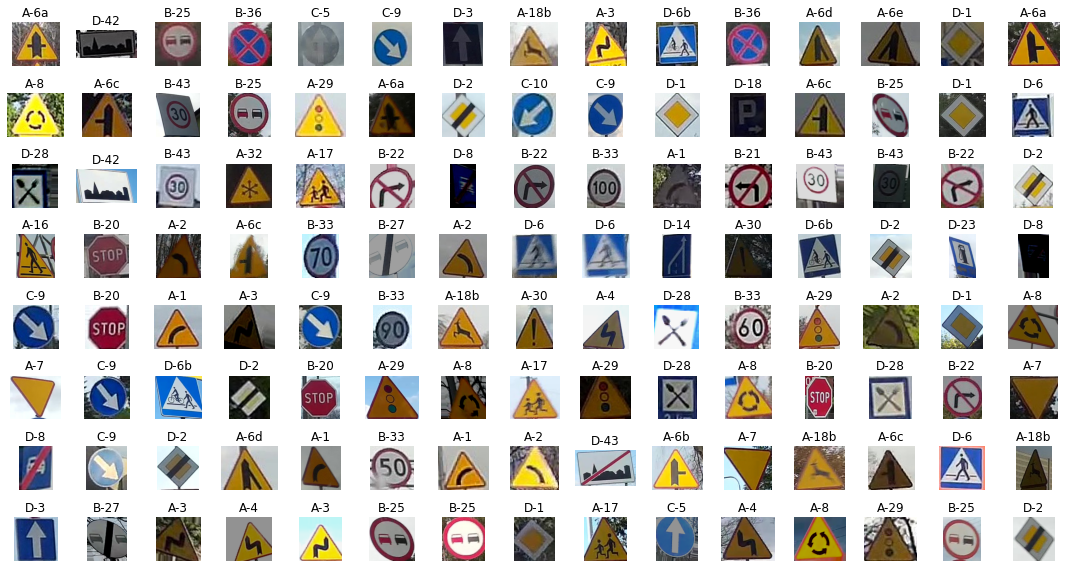

In [33]:
plt.rcParams['figure.figsize'] = (5, 5)
col = 15
row = 8
fig = plt.figure(figsize=(col, row))
for i in range(1,col*row + 1):
  fig.add_subplot(row, col, i)
  plt.axis('off')
  plt.imshow(images100_augmented_train[i][0])
  plt.title(f'{images100_augmented_train[i][1]}')
fig.tight_layout()
plt.show()

---

# 2. Learning

## 2.1 Over-sampled

### CNN: 2-4-4

In [63]:
model1 = models.Sequential()
model1.add(layers.Conv2D(2, (3, 3), activation='relu', input_shape=(IMG_ROWS, IMG_COLS, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(4, (3, 3), activation='relu'))
model1.add(layers.Flatten())
model1.add(layers.Dense(4, activation='relu'))
model1.add(layers.Dense(NUM_CLASSES_100, activation='softmax'))
model1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 2)         56        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 2)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 11, 11, 4)         76        
_________________________________________________________________
flatten_8 (Flatten)          (None, 484)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 1940      
_________________________________________________________________
dense_17 (Dense)             (None, 42)                210       
Total params: 2,282
Trainable params: 2,282
Non-trainable params: 0
____________________________________________________

In [64]:
model1.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['acc'])

history1 = model1.fit(x_sam_100_train, y_sam_100_train_labels, batch_size = 5, epochs=20, validation_data=(x_sam_100_valid,y_sam_100_valid_labels), verbose=1)

Epoch 1/20
1680/1680 [==============================] - 6s 3ms/step - loss: 3.5424 - acc: 0.0717 - val_loss: 2.7498 - val_acc: 0.2224
Epoch 2/20
1680/1680 [==============================] - 5s 3ms/step - loss: 2.3295 - acc: 0.2779 - val_loss: 1.9434 - val_acc: 0.4001
Epoch 3/20
1680/1680 [==============================] - 6s 4ms/step - loss: 1.7231 - acc: 0.4300 - val_loss: 1.8232 - val_acc: 0.4562
Epoch 4/20
1680/1680 [==============================] - 6s 3ms/step - loss: 1.5206 - acc: 0.4964 - val_loss: 1.9992 - val_acc: 0.4317
Epoch 5/20
1680/1680 [==============================] - 5s 3ms/step - loss: 1.4545 - acc: 0.5237 - val_loss: 1.7457 - val_acc: 0.5247
Epoch 6/20
1680/1680 [==============================] - 5s 3ms/step - loss: 1.3770 - acc: 0.5645 - val_loss: 1.7664 - val_acc: 0.5331
Epoch 7/20
1680/1680 [==============================] - 5s 3ms/step - loss: 1.3364 - acc: 0.5767 - val_loss: 1.7834 - val_acc: 0.5283
Epoch 8/20
1680/1680 [==============================] - 6s 4ms

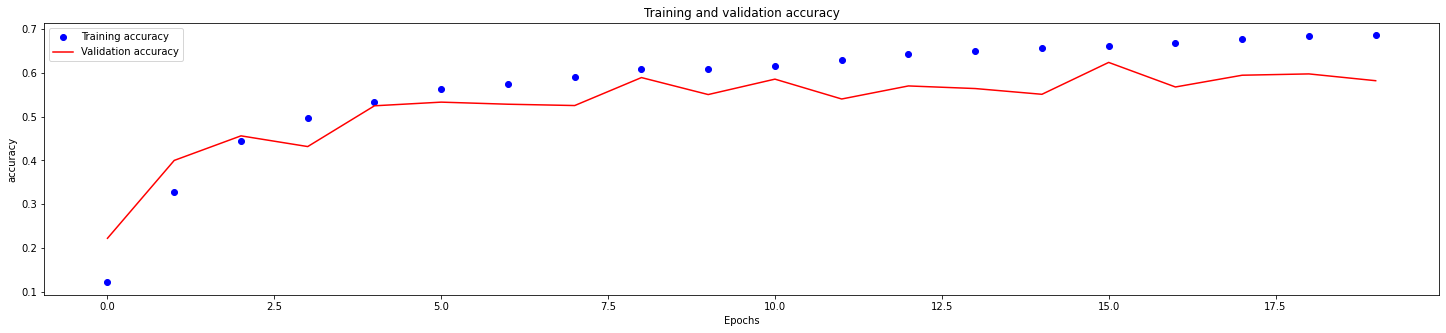

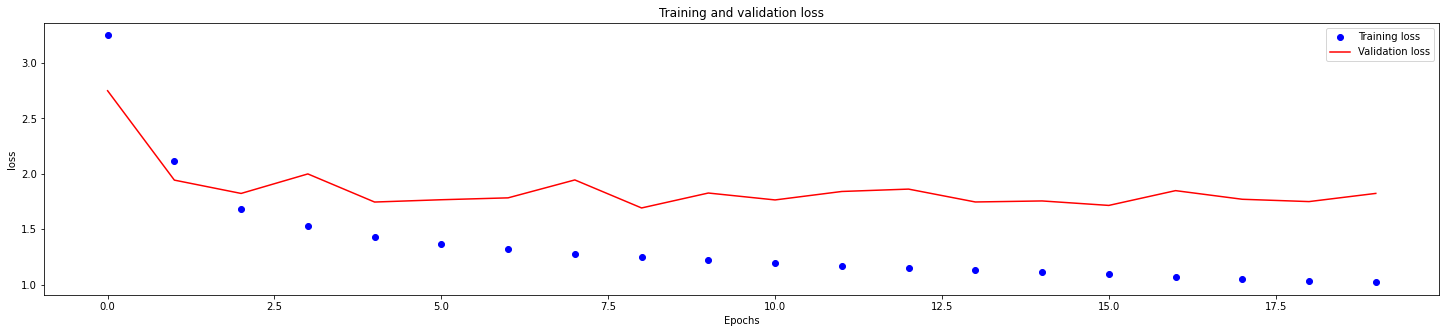

In [65]:
PlotTrainValComparison(history1.history['acc'], history1.history['val_acc'], "accuracy")
PlotTrainValComparison(history1.history['loss'], history1.history['val_loss'], "loss")

The network is definitely too small to work on such data.

### CNN: 4-8-8

In [66]:
model2 = models.Sequential()
model2.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(IMG_ROWS, IMG_COLS, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(8, (3, 3), activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(NUM_CLASSES_100, activation='softmax'))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 26, 26, 4)         112       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 4)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 11, 11, 8)         296       
_________________________________________________________________
flatten_9 (Flatten)          (None, 968)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 7752      
_________________________________________________________________
dense_19 (Dense)             (None, 42)                378       
Total params: 8,538
Trainable params: 8,538
Non-trainable params: 0
____________________________________________________

Epoch 1/20
1680/1680 - 5s - loss: 2.8599 - acc: 0.1711 - val_loss: 2.1578 - val_acc: 0.3083
Epoch 2/20
1680/1680 - 4s - loss: 1.7215 - acc: 0.4355 - val_loss: 1.7070 - val_acc: 0.4502
Epoch 3/20
1680/1680 - 4s - loss: 1.1915 - acc: 0.6335 - val_loss: 1.2383 - val_acc: 0.6225
Epoch 4/20
1680/1680 - 4s - loss: 0.8943 - acc: 0.7329 - val_loss: 1.2645 - val_acc: 0.6571
Epoch 5/20
1680/1680 - 4s - loss: 0.7599 - acc: 0.7807 - val_loss: 1.0285 - val_acc: 0.7293
Epoch 6/20
1680/1680 - 4s - loss: 0.6687 - acc: 0.8083 - val_loss: 1.2504 - val_acc: 0.6953
Epoch 7/20
1680/1680 - 4s - loss: 0.6099 - acc: 0.8300 - val_loss: 0.9800 - val_acc: 0.7621
Epoch 8/20
1680/1680 - 4s - loss: 0.5524 - acc: 0.8464 - val_loss: 0.9995 - val_acc: 0.7573
Epoch 9/20
1680/1680 - 4s - loss: 0.4879 - acc: 0.8701 - val_loss: 0.9627 - val_acc: 0.7800
Epoch 10/20
1680/1680 - 4s - loss: 0.4495 - acc: 0.8832 - val_loss: 0.8520 - val_acc: 0.8187
Epoch 11/20
1680/1680 - 4s - loss: 0.4104 - acc: 0.8890 - val_loss: 0.9555 - va

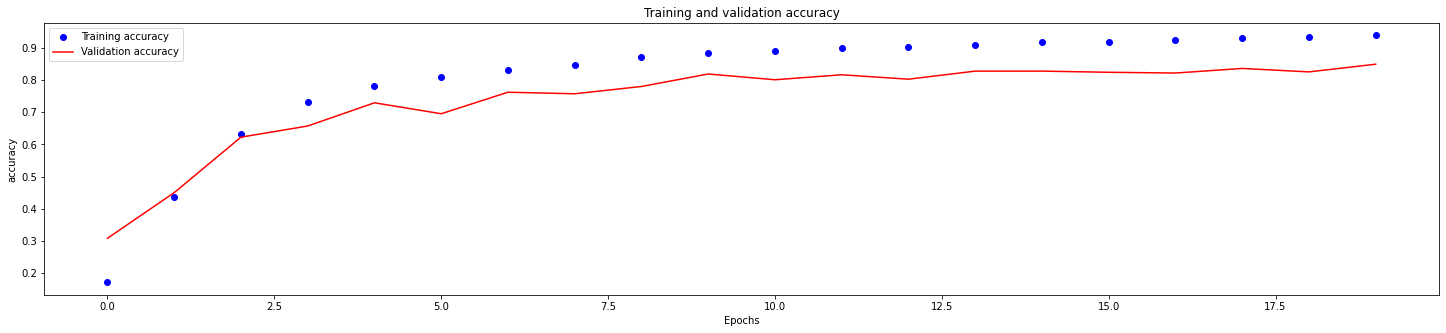

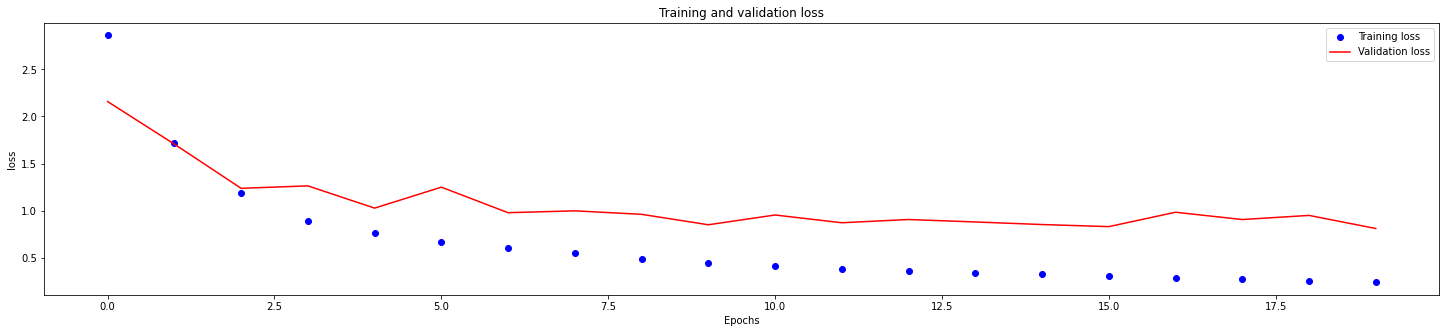

In [67]:
model2.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['acc'])

history2 = model2.fit(x_sam_100_train, y_sam_100_train_labels, batch_size = 5, epochs=20, validation_data=(x_sam_100_valid,y_sam_100_valid_labels), verbose=0)
PlotTrainValComparison(history2.history['acc'], history2.history['val_acc'], "accuracy")
PlotTrainValComparison(history2.history['loss'], history2.history['val_loss'], "loss")

In [73]:
argmax = np.argmax(history2.history['val_acc'])
acc_max = history2.history['val_acc'][argmax]
print ('The best accuracy ', acc_max, ' for validation set we achieved in epoch: ', argmax)
results = model3.evaluate(x_sam_100_test, y_sam_100_test_labels)

The best accuracy  0.8491353392601013  for validation set we achieved in epoch:  19
53/53 [==============================] - 0s 2ms/step - loss: 1.1649 - acc: 0.8737


I will increase # of nodes in network to maybe get some better results

### CNN: 4-8-16

In [70]:
model3 = models.Sequential()
model3.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(IMG_ROWS, IMG_COLS, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(8, (3, 3), activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.Dense(16, activation='relu'))
model3.add(layers.Dense(NUM_CLASSES_100, activation='softmax'))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 26, 26, 4)         112       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 4)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 11, 11, 8)         296       
_________________________________________________________________
flatten_10 (Flatten)         (None, 968)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                15504     
_________________________________________________________________
dense_21 (Dense)             (None, 42)                714       
Total params: 16,626
Trainable params: 16,626
Non-trainable params: 0
_________________________________________________

Epoch 1/20
1680/1680 [==============================] - 7s 4ms/step - loss: 2.9606 - acc: 0.2038 - val_loss: 1.0988 - val_acc: 0.6702
Epoch 2/20
1680/1680 [==============================] - 5s 3ms/step - loss: 0.8532 - acc: 0.7581 - val_loss: 0.8083 - val_acc: 0.7728
Epoch 3/20
1680/1680 [==============================] - 5s 3ms/step - loss: 0.4496 - acc: 0.8767 - val_loss: 0.7248 - val_acc: 0.8259
Epoch 4/20
1680/1680 [==============================] - 6s 3ms/step - loss: 0.3182 - acc: 0.9140 - val_loss: 0.6521 - val_acc: 0.8509
Epoch 5/20
1680/1680 [==============================] - 5s 3ms/step - loss: 0.2452 - acc: 0.9383 - val_loss: 0.5976 - val_acc: 0.8784
Epoch 6/20
1680/1680 [==============================] - 5s 3ms/step - loss: 0.2128 - acc: 0.9521 - val_loss: 0.8057 - val_acc: 0.8330
Epoch 7/20
1680/1680 [==============================] - 5s 3ms/step - loss: 0.1790 - acc: 0.9519 - val_loss: 0.6997 - val_acc: 0.8658
Epoch 8/20
1680/1680 [==============================] - 6s 3ms

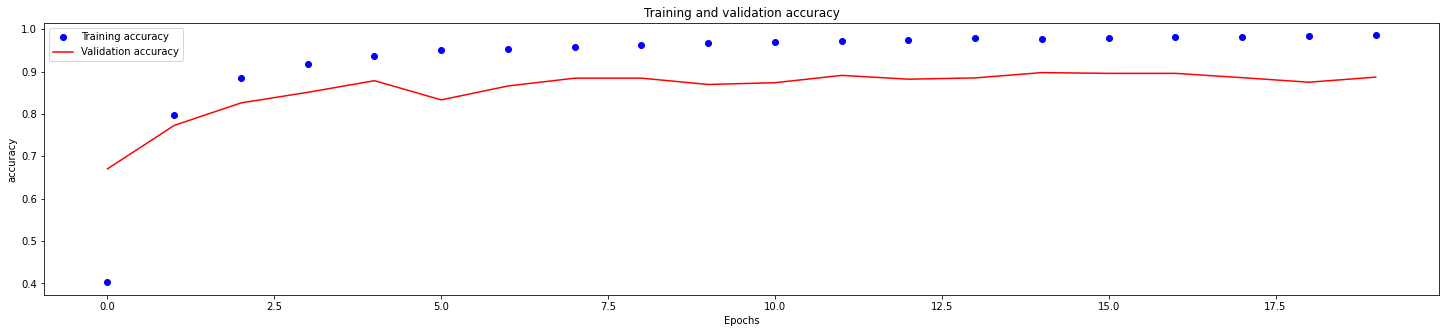

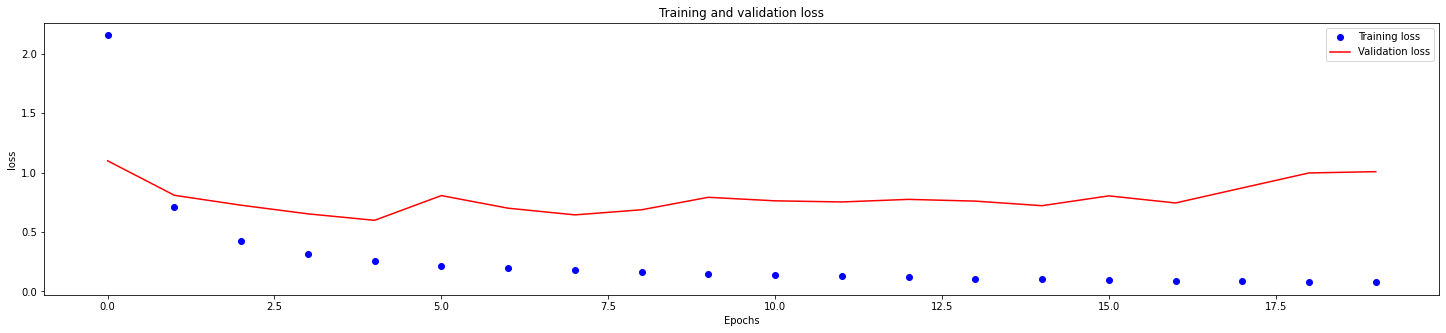

In [71]:
model3.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['acc'])

history3 = model3.fit(x_sam_100_train, y_sam_100_train_labels, batch_size = 5, epochs=20, validation_data=(x_sam_100_valid,y_sam_100_valid_labels), verbose=0)
PlotTrainValComparison(history3.history['acc'], history3.history['val_acc'], "accuracy")
PlotTrainValComparison(history3.history['loss'], history3.history['val_loss'], "loss")

In [72]:
argmax = np.argmax(history3.history['val_acc'])
acc_max = history3.history['val_acc'][argmax]
print ('The best accuracy ', acc_max, ' for validation set we achieved in epoch: ', argmax)
results = model3.evaluate(x_sam_100_test, y_sam_100_test_labels)

The best accuracy  0.8974359035491943  for validation set we achieved in epoch:  14
53/53 [==============================] - 0s 2ms/step - loss: 1.1649 - acc: 0.8737


### CNN: 8-8-16

In [74]:
model4 = models.Sequential()
model4.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(IMG_ROWS, IMG_COLS, 3)))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(8, (3, 3), activation='relu'))
model4.add(layers.Flatten())
model4.add(layers.Dense(16, activation='relu'))
model4.add(layers.Dense(NUM_CLASSES_100, activation='softmax'))
model4.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 26, 26, 8)         224       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 11, 11, 8)         584       
_________________________________________________________________
flatten_11 (Flatten)         (None, 968)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                15504     
_________________________________________________________________
dense_23 (Dense)             (None, 42)                714       
Total params: 17,026
Trainable params: 17,026
Non-trainable params: 0
_________________________________________________

Epoch 1/20
1680/1680 [==============================] - 7s 4ms/step - loss: 2.6737 - acc: 0.2803 - val_loss: 1.1293 - val_acc: 0.6774
Epoch 2/20
1680/1680 [==============================] - 6s 3ms/step - loss: 0.6834 - acc: 0.7972 - val_loss: 0.7514 - val_acc: 0.8157
Epoch 3/20
1680/1680 [==============================] - 6s 3ms/step - loss: 0.3544 - acc: 0.9041 - val_loss: 0.5756 - val_acc: 0.8772
Epoch 4/20
1680/1680 [==============================] - 5s 3ms/step - loss: 0.2480 - acc: 0.9334 - val_loss: 0.6315 - val_acc: 0.8772
Epoch 5/20
1680/1680 [==============================] - 5s 3ms/step - loss: 0.1850 - acc: 0.9541 - val_loss: 0.6208 - val_acc: 0.8873
Epoch 6/20
1680/1680 [==============================] - 5s 3ms/step - loss: 0.1435 - acc: 0.9630 - val_loss: 0.6564 - val_acc: 0.8951
Epoch 7/20
1680/1680 [==============================] - 6s 4ms/step - loss: 0.1230 - acc: 0.9681 - val_loss: 0.7456 - val_acc: 0.8855
Epoch 8/20
1680/1680 [==============================] - 5s 3ms

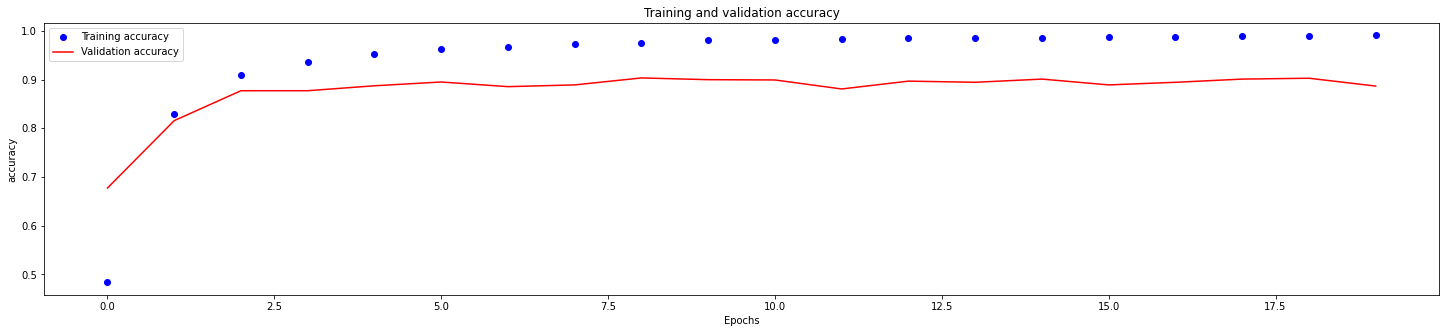

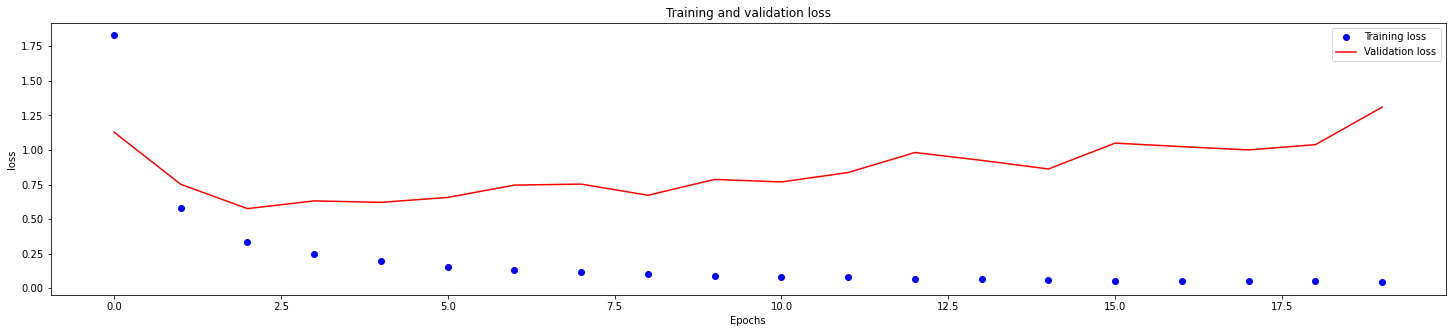

In [75]:
model4.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['acc'])

history4 = model4.fit(x_sam_100_train, y_sam_100_train_labels, batch_size = 5, epochs=20, validation_data=(x_sam_100_valid,y_sam_100_valid_labels), verbose=1)
PlotTrainValComparison(history4.history['acc'], history4.history['val_acc'], "accuracy")
PlotTrainValComparison(history4.history['loss'], history4.history['val_loss'], "loss")

In [76]:
argmax = np.argmax(history4.history['val_acc'])
acc_max = history4.history['val_acc'][argmax]
print ('The best accuracy ', acc_max, ' for validation set we achieved in epoch: ', argmax)
results = model4.evaluate(x_sam_100_test, y_sam_100_test_labels)

The best accuracy  0.9033989310264587  for validation set we achieved in epoch:  8
53/53 [==============================] - 0s 3ms/step - loss: 1.3336 - acc: 0.8784


After seeing results of 4 presented models I will focus on the 3rd one. The 4th model has higher accuracy, but it started over-fitting quite quickly (after around 6th epoch)

### Tweaking CNN: 4-8-16

In [79]:
# learning_rate=0.001 -> loss: 1.0727 - acc: 0.8897
# learning_rate=0.002 -> loss: 1.5726 - acc: 0.8880
# learning_rate=0.003 -> loss: 2.1752 - acc: 0.8737

opt = optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['acc'])

history3 = model3.fit(x_sam_100_train, y_sam_100_train_labels, batch_size = 5, epochs=20, validation_data=(x_sam_100_valid,y_sam_100_valid_labels), verbose=0)
results = model3.evaluate(x_sam_100_test, y_sam_100_test_labels)

53/53 [==============================] - 0s 2ms/step - loss: 2.1752 - acc: 0.8737


## 2.2 Augmented

Size of the data set is the same as in case of the Over-sampled dataset so I will stick with the last CNN size

### Learning rate reduction

In [104]:
model6 = models.Sequential()
model6.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(IMG_ROWS, IMG_COLS, 3)))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Conv2D(8, (3, 3), activation='relu'))
model6.add(layers.Flatten())
model6.add(layers.Dense(16, activation='relu'))
model6.add(layers.Dense(NUM_CLASSES_100, activation='softmax'))
# ---
opt = optimizers.Adam(learning_rate=0.001)
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
         factor=0.5,
         patience=5,
         verbose=1,
         min_lr=0.001)

model6.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['acc'])

history6 = model6.fit(x_aug_100_train, y_aug_100_train_labels, batch_size = 5, epochs=20, validation_data=(x_aug_100_valid,y_aug_100_valid_labels), verbose=0, callbacks = [learning_rate_reduction])
results = model6.evaluate(x_aug_100_test, y_aug_100_test_labels)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


53/53 [==============================] - 0s 2ms/step - loss: 0.7894 - acc: 0.8594


### Sigmoid

In [105]:
model7 = models.Sequential()
model7.add(layers.Conv2D(4, (3, 3), activation='sigmoid', input_shape=(IMG_ROWS, IMG_COLS, 3)))
model7.add(layers.MaxPooling2D((2, 2)))
model7.add(layers.Conv2D(8, (3, 3), activation='sigmoid'))
model7.add(layers.Flatten())
model7.add(layers.Dense(16, activation='sigmoid'))
model7.add(layers.Dense(NUM_CLASSES_100, activation='softmax'))
# ---
opt = optimizers.Adam(learning_rate=0.001)
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
         factor=0.5,
         patience=5,
         verbose=1,
         min_lr=0.001)

model7.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['acc'])

history7 = model7.fit(x_aug_100_train, y_aug_100_train_labels, batch_size = 5, epochs=20, validation_data=(x_aug_100_valid,y_aug_100_valid_labels), verbose=0, callbacks = [learning_rate_reduction])
results = model7.evaluate(x_aug_100_test, y_aug_100_test_labels)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


53/53 [==============================] - 0s 3ms/step - loss: 0.5414 - acc: 0.8605


## 2.3 200

### Plain one - more nodes in CNN

In [114]:
model9 = models.Sequential()
model9.add(layers.Conv2D(4, (3, 3), activation='sigmoid', input_shape=(IMG_ROWS, IMG_COLS, 3)))
model9.add(layers.MaxPooling2D((2, 2)))
model9.add(layers.Conv2D(12, (3, 3), activation='sigmoid'))
model9.add(layers.Flatten())
model9.add(layers.Dense(16, activation='sigmoid'))
model9.add(layers.Dense(NUM_CLASSES_200, activation='softmax'))

model9.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['acc'])

history9 = model9.fit(x_200_train, y_200_train_labels, batch_size = 5, epochs=20, validation_data=(x_200_valid,y_200_valid_labels), verbose=0)
results = model9.evaluate(x_200_test, y_200_test_labels)

41/41 [==============================] - 0s 2ms/step - loss: 0.3510 - acc: 0.8994


### Adam optimizer

In [112]:
model10 = models.Sequential()
model10.add(layers.Conv2D(4, (3, 3), activation='sigmoid', input_shape=(IMG_ROWS, IMG_COLS, 3)))
model10.add(layers.MaxPooling2D((2, 2)))
model10.add(layers.Conv2D(12, (3, 3), activation='sigmoid'))
model10.add(layers.Flatten())
model10.add(layers.Dense(16, activation='sigmoid'))
model10.add(layers.Dense(NUM_CLASSES_200, activation='softmax'))

opt = optimizers.Adam(learning_rate=0.001)
model10.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['acc'])

history10 = model10.fit(x_200_train, y_200_train_labels, batch_size = 5, epochs=20, validation_data=(x_200_valid,y_200_valid_labels), verbose=0)
results = model10.evaluate(x_200_test, y_200_test_labels)

41/41 [==============================] - 0s 2ms/step - loss: 0.2593 - acc: 0.9203


### Relu activation function

In [113]:
model11 = models.Sequential()
model11.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(IMG_ROWS, IMG_COLS, 3)))
model11.add(layers.MaxPooling2D((2, 2)))
model11.add(layers.Conv2D(12, (3, 3), activation='relu'))
model11.add(layers.Flatten())
model11.add(layers.Dense(16, activation='relu'))
model11.add(layers.Dense(NUM_CLASSES_200, activation='softmax'))

opt = optimizers.Adam(learning_rate=0.001)
model11.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['acc'])

history11 = model11.fit(x_200_train, y_200_train_labels, batch_size = 5, epochs=20, validation_data=(x_200_valid,y_200_valid_labels), verbose=0)
results = model11.evaluate(x_200_test, y_200_test_labels)

41/41 [==============================] - 0s 3ms/step - loss: 0.3893 - acc: 0.9365


## 2.4 Whole dataset

### Classical one

In [92]:
total_count = sum(train_signs_counts)

weights = {}
for i in range(0, len(train_signs_dirs)):
  weights[i] = (1/(train_signs_counts[i])) * (total_count/2.0)

Epoch 1/50
559/559 [==============================] - 3s 5ms/step - loss: 206.0385 - acc: 0.0626 - val_loss: 2.8001 - val_acc: 0.3104
Epoch 2/50
559/559 [==============================] - 2s 4ms/step - loss: 118.2811 - acc: 0.4148 - val_loss: 2.0574 - val_acc: 0.4695
Epoch 3/50
559/559 [==============================] - 2s 4ms/step - loss: 87.1997 - acc: 0.5701 - val_loss: 1.8928 - val_acc: 0.5430
Epoch 4/50
559/559 [==============================] - 2s 4ms/step - loss: 70.8255 - acc: 0.6486 - val_loss: 1.8392 - val_acc: 0.5449
Epoch 5/50
559/559 [==============================] - 2s 4ms/step - loss: 57.2372 - acc: 0.7132 - val_loss: 1.5084 - val_acc: 0.6422
Epoch 6/50
559/559 [==============================] - 2s 4ms/step - loss: 51.8531 - acc: 0.7420 - val_loss: 1.5599 - val_acc: 0.6245
Epoch 7/50
559/559 [==============================] - 2s 4ms/step - loss: 44.0968 - acc: 0.7691 - val_loss: 1.4558 - val_acc: 0.6645
Epoch 8/50
559/559 [==============================] - 2s 4ms/step -

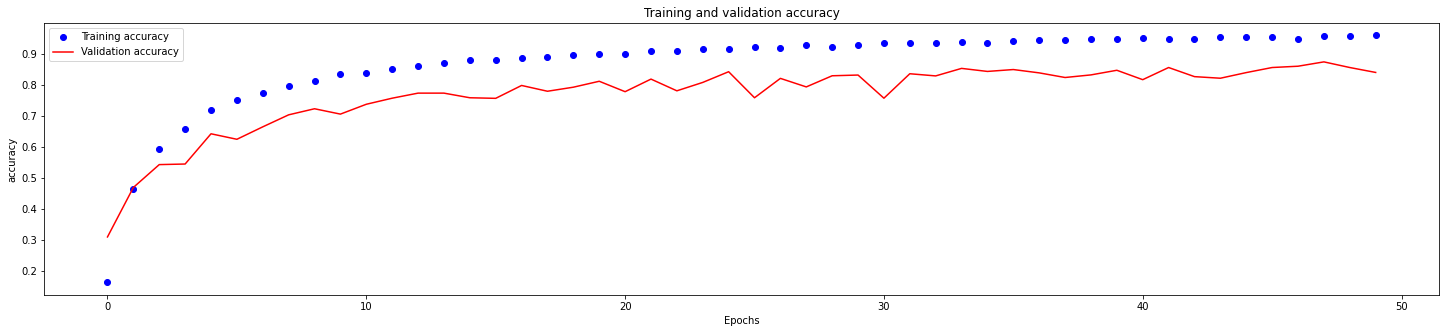

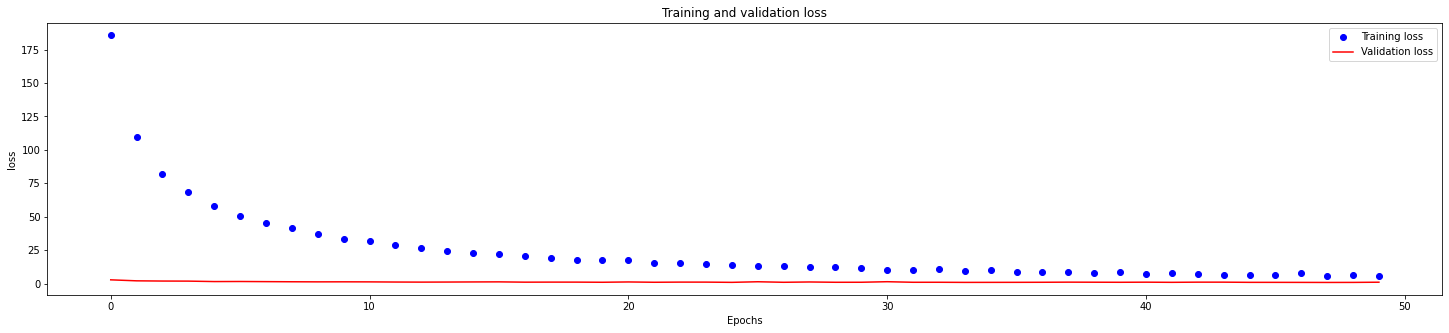

68/68 [==============================] - 0s 2ms/step - loss: 1.0508 - acc: 0.8269


In [115]:
model5 = models.Sequential()
model5.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(IMG_ROWS, IMG_COLS, 3)))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(16,(3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(layers.Conv2D(8, (3, 3), activation='relu'))
model5.add(layers.Flatten())
model5.add(layers.Dense(16, activation='relu'))
model5.add(layers.Dense(92, activation='softmax'))
# ---
opt = optimizers.Adam(learning_rate=0.001)
model5.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['acc'])

history5 = model5.fit(x_train, y_train_labels, batch_size = 30, epochs=50, validation_data=(x_valid,y_valid_labels), verbose=1, class_weight=weights)
PlotTrainValComparison(history5.history['acc'], history5.history['val_acc'], "accuracy")
PlotTrainValComparison(history5.history['loss'], history5.history['val_loss'], "loss")
results = model5.evaluate(x_test, y_test_labels)

### Adam optimizer

In [148]:
model11 = models.Sequential()
model11.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(IMG_ROWS, IMG_COLS, 3)))
model11.add(layers.MaxPooling2D((2, 2)))
model11.add(layers.Conv2D(16,(3, 3), activation='relu'))
model11.add(MaxPooling2D(pool_size=(2, 2)))
model11.add(layers.Conv2D(8, (3, 3), activation='relu'))
model11.add(layers.Flatten())
model11.add(layers.Dense(16, activation='relu'))
model11.add(layers.Dense(92, activation='softmax'))
# ---
opt = optimizers.Adam(learning_rate=0.001)
model11.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['acc'])

history11 = model11.fit(x_train, y_train_labels, batch_size = 30, epochs=50, validation_data=(x_valid,y_valid_labels), verbose=1, class_weight=weights)
results = model11.evaluate(x_test, y_test_labels)

Epoch 1/50
559/559 [==============================] - 3s 5ms/step - loss: 201.4024 - acc: 0.0355 - val_loss: 3.0312 - val_acc: 0.1661
Epoch 2/50
559/559 [==============================] - 2s 4ms/step - loss: 133.8968 - acc: 0.2811 - val_loss: 2.1009 - val_acc: 0.4039
Epoch 3/50
559/559 [==============================] - 2s 4ms/step - loss: 96.9704 - acc: 0.4804 - val_loss: 1.9169 - val_acc: 0.4784
Epoch 4/50
559/559 [==============================] - 2s 4ms/step - loss: 73.0968 - acc: 0.5973 - val_loss: 1.7027 - val_acc: 0.5393
Epoch 5/50
559/559 [==============================] - 2s 4ms/step - loss: 58.2919 - acc: 0.6603 - val_loss: 1.5505 - val_acc: 0.5872
Epoch 6/50
559/559 [==============================] - 2s 4ms/step - loss: 51.0554 - acc: 0.7120 - val_loss: 1.4446 - val_acc: 0.6291
Epoch 7/50
559/559 [==============================] - 2s 4ms/step - loss: 42.9182 - acc: 0.7503 - val_loss: 1.3289 - val_acc: 0.6650
Epoch 8/50
559/559 [==============================] - 2s 4ms/step -

# Intermediate activations visualization

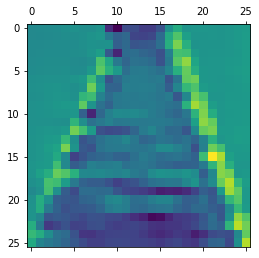

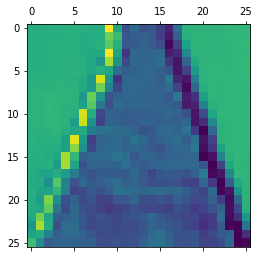

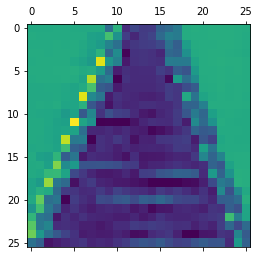

In [147]:
from keras.models import load_model
from keras.preprocessing import image
img_path = '/content/drive/MyDrive/PolishTrafficSignsRecognition/test/A-21/2019_0721_181936_005 726_0.jpg'

model = model11
img = image.load_img(img_path, target_size=(28, 28))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

from keras import models
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:3]]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

import matplotlib.pyplot as plt
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
plt.show()
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
plt.show()
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')
plt.show()

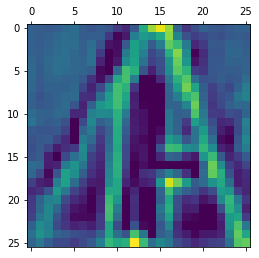

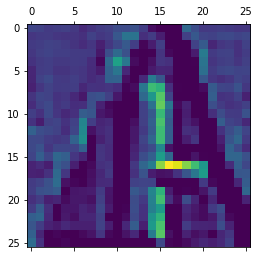

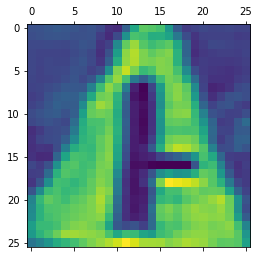

In [151]:
from keras.models import load_model
from keras.preprocessing import image
img_path = '/content/drive/MyDrive/PolishTrafficSignsRecognition/test/A-6b/2019_0719_142601_003 0658_0.jpg'

model = model11
img = image.load_img(img_path, target_size=(28, 28))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

from keras import models
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:3]]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

import matplotlib.pyplot as plt
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
plt.show()
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
plt.show()
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')
plt.show()

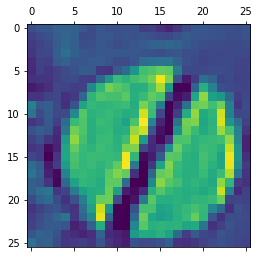

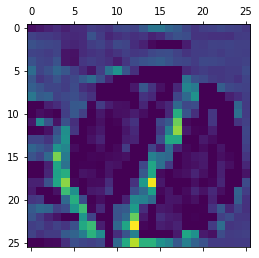

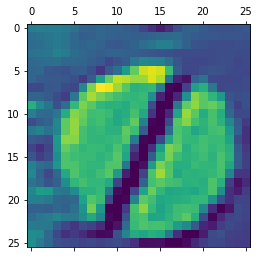

In [152]:
from keras.models import load_model
from keras.preprocessing import image
img_path = '/content/drive/MyDrive/PolishTrafficSignsRecognition/test/B-42/2019_0809_162432_004 0214_0.jpg'

model = model11
img = image.load_img(img_path, target_size=(28, 28))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

from keras import models
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:3]]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

import matplotlib.pyplot as plt
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
plt.show()
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
plt.show()
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')
plt.show()

# Comparison

[Source- Tomasz Kacmajor](https://tomaszkacmajor.pl/index.php/2017/10/15/traffic-sign-recognition-using-cnn/)

Test set accuracy = 94.6 %

My highest test set accuracy = 93.65 %


# Summary / Take-aways

- the best model was the one which operated on 200 samples of each image, enhanced with Adam optimizer
- when dealing with imbalanced data we should try to balance it (*collect more data*)
- there are some other ways of balancing data, but they have some drawbacks (repetition of samples)